In [1]:
import csv 
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SpotifySongs").getOrCreate()

df = spark.read.csv("../../assets/data/spotify-2023.csv", header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/12 14:24:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


### 1. Most Streamed & Highest Ranking Tracks
* Identify the top 5 tracks with the highest number of streams in 2023.
* Identify the top 5 ranking tracks across all platforms.
* Is there any crossover between these two findings?

In [2]:
df.dtypes

[('track_name', 'string'),
 ('artist(s)_name', 'string'),
 ('artist_count', 'int'),
 ('released_year', 'int'),
 ('released_month', 'int'),
 ('released_day', 'int'),
 ('in_spotify_playlists', 'int'),
 ('in_spotify_charts', 'int'),
 ('streams', 'string'),
 ('in_apple_playlists', 'int'),
 ('in_apple_charts', 'int'),
 ('in_deezer_playlists', 'string'),
 ('in_deezer_charts', 'int'),
 ('in_shazam_charts', 'string'),
 ('bpm', 'int'),
 ('key', 'string'),
 ('mode', 'string'),
 ('danceability_%', 'int'),
 ('valence_%', 'int'),
 ('energy_%', 'int'),
 ('acousticness_%', 'int'),
 ('instrumentalness_%', 'int'),
 ('liveness_%', 'int'),
 ('speechiness_%', 'int')]

#### Top 5 tracks with the highest number of streams in 2023

In [3]:
df.select("track_name", "artist(s)_name", "released_year", "streams").orderBy(df.streams.cast('int').desc()).show(5)

+-----------------+--------------+-------------+----------+
|       track_name|artist(s)_name|released_year|   streams|
+-----------------+--------------+-------------+----------+
|Take Me To Church|        Hozier|         2013|2135158446|
|          Circles|   Post Malone|         2019|2132335812|
|    Love Yourself| Justin Bieber|         2015|2123309722|
|        All of Me|   John Legend|         2013|2086124197|
|   Counting Stars|   OneRepublic|         2013|2011464183|
+-----------------+--------------+-------------+----------+
only showing top 5 rows



#### Top 5 ranking tracks across all platforms

In [4]:
total_charts_presence_df = df.withColumn("total_charts_presence", df.in_spotify_charts + df.in_apple_charts + df.in_deezer_charts + df.in_shazam_charts)

In [5]:
total_charts_presence_df.select("track_name", "artist(s)_name", "released_year", "total_charts_presence").orderBy(total_charts_presence_df.total_charts_presence.desc()).show(5)

+--------------------+-----------------+-------------+---------------------+
|          track_name|   artist(s)_name|released_year|total_charts_presence|
+--------------------+-----------------+-------------+---------------------+
|             vampire|   Olivia Rodrigo|         2023|               1283.0|
|            Sprinter|Dave, Central Cee|         2023|               1267.0|
|            fukumean|            Gunna|         2023|               1257.0|
|Seven (feat. Latt...| Latto, Jung Kook|         2023|               1246.0|
|              Tattoo|           Loreen|         2023|               1104.0|
+--------------------+-----------------+-------------+---------------------+
only showing top 5 rows



#### Is there any crossover between these two findings?

I didn't see any cross over between these two findings, all thet tracks are different that were the top 5 most streamed and the top 5 highest ranked across all platforms.

### 2. Artists with Most Tracks in Spotify Charts:

* Group by the artist's name and count how many of their tracks made it to the Spotify charts. Display the top 10 artists.

In [6]:
top_artists = df.filter(df.in_spotify_charts != 0).groupBy("artist(s)_name").count()

In [7]:
top_artists.orderBy(top_artists["count"].desc()).show(10)

+--------------+-----+
|artist(s)_name|count|
+--------------+-----+
|  Taylor Swift|   22|
|     Bad Bunny|   12|
|  Harry Styles|   10|
|    The Weeknd|    8|
|          Feid|    7|
| Morgan Wallen|    6|
|    Ed Sheeran|    6|
|      NewJeans|    6|
|Olivia Rodrigo|    5|
|       Karol G|    4|
+--------------+-----+
only showing top 10 rows



### 3. Filter and Select Attributes of Danceable Tracks:

* Extract tracks with a danceability percentage of more than 80% and display their name, artist, bpm (beats per minute), and danceability percentage.
* Identify any possible correlation between danceability and bpm.

In [9]:
danceable_tracks = df.select("track_name", "artist(s)_name", "bpm", "danceability_%").filter(df["danceability_%"] > 80)
danceable_tracks.show()

+--------------------+--------------------+---+--------------+
|          track_name|      artist(s)_name|bpm|danceability_%|
+--------------------+--------------------+---+--------------+
|            Sprinter|   Dave, Central Cee|141|            92|
|            fukumean|               Gunna|130|            85|
|     La Bebe - Remix|Peso Pluma, Yng L...|170|            81|
|          Classy 101|    Feid, Young Miko|100|            86|
|Peso Pluma: Bzrp ...|Bizarrap, Peso Pluma|133|            85|
|Popular (with Pla...|The Weeknd, Madon...| 99|            85|
|        MOJABI GHOST|    Tainy, Bad Bunny|122|            81|
|     Los del Espacio|Big One, Duki, Li...|120|            81|
|            AMARGURA|             Karol G|107|            92|
|          La Bachata|       Manuel Turizo|125|            84|
|                 S91|             Karol G|128|            86|
|                 T��|dennis, MC Kevin ...|130|            86|
|Left and Right (F...|Charlie Puth, BTS...|101|        

To see if there is any correlation I believe we should check the correlation between danceability and bpm

In [10]:
danceable_tracks.stat.corr("danceability_%", "bpm")

0.016846197056879803

Base on the data analysis module we did before, anything between 0 to 0.18 is considered weak according to the British Medical Journal. From this it seems the correlation is low but it's good to double check how this is visually before jumping into conclusions. 

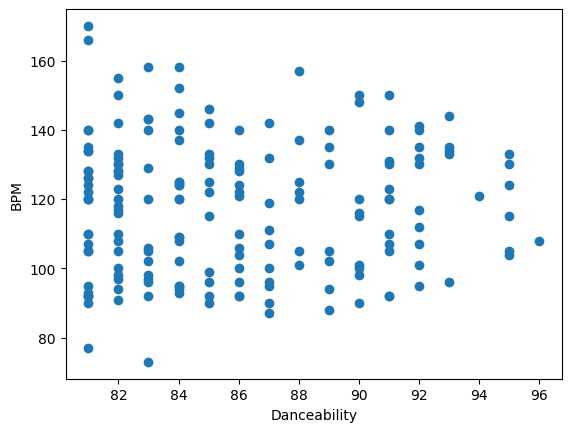

In [13]:
import matplotlib.pyplot as plt

plt.scatter(danceable_tracks.select("danceability_%").collect(), danceable_tracks.select("bpm").collect())
plt.xlabel("Danceability")
plt.ylabel("BPM")
plt.show()

From this we can confirm that the data points are scattered all over and that there is no trend, correlation between danceability and bpm.